# Imports

In [6]:
from glob import glob
import xarray as xr
from typing import List, Optional
import numpy as np

# Constants

In [7]:
S2_SCALE_FACTOR = 1e-4
S2_BANDS = [
    "aot",
    "blue",
    "coastal",
    "green",
    "nir",
    "nir08",
    "nir09",
    "red",
    "rededge1",
    "rededge2",
    "rededge3",
    "swir16",
    "swir22",
]

# Read in patches

In [18]:
patches = []
for patch_s3_key in glob("Archive/*"):
    patch = xr.open_zarr(patch_s3_key,consolidated=False)
    patches.append(patch)

In [19]:
patches

[<xarray.Dataset> Size: 907kB
 Dimensions:   (time: 112, y: 17, x: 17)
 Coordinates:
     epsg      int64 8B ...
   * time      (time) datetime64[ns] 896B 2021-01-05T03:34:59.828000 ... 2021-...
   * x         (x) float64 136B 105.4 105.4 105.4 105.4 ... 105.4 105.4 105.4
   * y         (y) float64 136B 11.5 11.5 11.5 11.5 11.5 ... 11.5 11.5 11.5 11.5
 Data variables: (12/14)
     aot       (time, y, x) uint16 65kB ...
     blue      (time, y, x) uint16 65kB ...
     coastal   (time, y, x) uint16 65kB ...
     green     (time, y, x) uint16 65kB ...
     nir       (time, y, x) uint16 65kB ...
     nir08     (time, y, x) uint16 65kB ...
     ...        ...
     rededge1  (time, y, x) uint16 65kB ...
     rededge2  (time, y, x) uint16 65kB ...
     rededge3  (time, y, x) uint16 65kB ...
     scl       (time, y, x) uint16 65kB ...
     swir16    (time, y, x) uint16 65kB ...
     swir22    (time, y, x) uint16 65kB ...
 Attributes: (12/25)
     beam:                     11
     captured_time

# Inspect one patch

In [20]:
patch = patches[0]
patch

<xarray.Dataset> Size: 907kB
Dimensions:   (time: 112, y: 17, x: 17)
Coordinates:
    epsg      int64 8B ...
  * time      (time) datetime64[ns] 896B 2021-01-05T03:34:59.828000 ... 2021-...
  * x         (x) float64 136B 105.4 105.4 105.4 105.4 ... 105.4 105.4 105.4
  * y         (y) float64 136B 11.5 11.5 11.5 11.5 11.5 ... 11.5 11.5 11.5 11.5
Data variables: (12/14)
    aot       (time, y, x) uint16 65kB ...
    blue      (time, y, x) uint16 65kB ...
    coastal   (time, y, x) uint16 65kB ...
    green     (time, y, x) uint16 65kB ...
    nir       (time, y, x) uint16 65kB ...
    nir08     (time, y, x) uint16 65kB ...
    ...        ...
    rededge1  (time, y, x) uint16 65kB ...
    rededge2  (time, y, x) uint16 65kB ...
    rededge3  (time, y, x) uint16 65kB ...
    scl       (time, y, x) uint16 65kB ...
    swir16    (time, y, x) uint16 65kB ...
    swir22    (time, y, x) uint16 65kB ...
Attributes: (12/25)
    beam:                     11
    captured_time:            2021-07-31T05:18:52
    cover_z_0:                0.003326727543026209
    cover_z_1:                0.0
    cover_z_2:                0.0
    crs:                      epsg:4326
    ...                       ...
    resolution_xy:            [9.178152488686919e-05, 9.043544548426041e-05]
    rh100:                    325
    sensitivity:              0.9318493008613586
    shot_number:              149101100200061491
    solar_elevation:          82.6844482421875
    transform:                [9.178152488686919e-05, 0.0, 105.29993390593127...

Here we have one sample that is loaded in as an xarray dataset (https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). The coordinates describe fixed/independent quantities (ie. time, x and y), the data variables describe varying/dependent quantities (eg. RGB bands) and the attributes describe global attributes that apply to the dataset as a whole.

Any given patch covers a 17x17 pixel patch (each pixel is 10mx10m) across an entire year. The variables are then different imaging bands detected by the satellite and can have different spatial resolutions (https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/). In addition to the spectral bands there is an SCL (scene classification layer) variable which describes a class that has been predicted for each pixel, this includes classes such as 'snow', 'vegetated' or 'high probability cloud' (https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/). The SCL layer is very helpful in filtering out unwanted pixels such as likely cloud, however it is not perfect and will not remove all of the cloud pixels.

In the attributes you will find matched data relating to the GEDI measurements (https://gedi.umd.edu/data/products/). The target we want to predict is the `cover_z_1` attribute that measures the canopy cover above 5m. Other useful attributes are hte `captured_time` which is when the GEDI measurement was made and the `longitude_bin0`/`latitude_bin0` which is the centre of the GEDI beam.

# Basic Transformations

In [21]:
def scale_sentinel_bands(dataset: xr.Dataset, bands: List[str]) -> xr.Dataset:
    """Apply scaling factor to convert uint16 values to float32 (0-1).

    https://github.com/Element84/earth-search/issues/23

    Args:
        dataset: Dataset to scale
        bands: Bands to scale

    Returns:
        Scaled dataset
    """
    dataset[bands] = (dataset[bands] * S2_SCALE_FACTOR).astype(np.float32)

    return dataset

def get_scl_mask(dataset: xr.Dataset, scl_classes: List[int]) -> np.array:
    """Generate a mask for the given scl classes.

    Args:
        dataset: Dataset to filter
        scl_classes: List of scl classes to filter by

    Returns:
        Boolean mask of scl classes
    """
    return dataset["scl"].isin(scl_classes).values

def apply_mask(
    dataset: xr.Dataset, mask: np.array, flatten_time_dim: bool
) -> xr.Dataset:
    """Apply a mask to a dataset.

    Args:
        dataset: Dataset to filter
        mask: Mask to apply
        flatten_time_dim: Whether to flatten the time dimension

    Returns:
        Dataset with mask applied
    """
    if flatten_time_dim:
        return dataset.where(mask).min(dim="time", skipna=True)
    else:
        return dataset.where(mask)

In [22]:
scaled_patch = scale_sentinel_bands(patch, S2_BANDS)

scl_mask = get_scl_mask(scaled_patch, scl_classes=[4,5])
masked_patch = apply_mask(scaled_patch, scl_mask, flatten_time_dim=False)
masked_patch

<xarray.Dataset> Size: 2MB
Dimensions:   (time: 112, y: 17, x: 17)
Coordinates:
    epsg      int64 8B ...
  * time      (time) datetime64[ns] 896B 2021-01-05T03:34:59.828000 ... 2021-...
  * x         (x) float64 136B 105.4 105.4 105.4 105.4 ... 105.4 105.4 105.4
  * y         (y) float64 136B 11.5 11.5 11.5 11.5 11.5 ... 11.5 11.5 11.5 11.5
Data variables: (12/14)
    aot       (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    blue      (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    coastal   (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    green     (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    nir       (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    nir08     (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    ...        ...
    rededge1  (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    rededge2  (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    rededge3  (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    scl       (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    swir16    (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    swir22    (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/25)
    beam:                     11
    captured_time:            2021-07-31T05:18:52
    cover_z_0:                0.003326727543026209
    cover_z_1:                0.0
    cover_z_2:                0.0
    crs:                      epsg:4326
    ...                       ...
    resolution_xy:            [9.178152488686919e-05, 9.043544548426041e-05]
    rh100:                    325
    sensitivity:              0.9318493008613586
    shot_number:              149101100200061491
    solar_elevation:          82.6844482421875
    transform:                [9.178152488686919e-05, 0.0, 105.29993390593127...

Here we have scaled the sentinel bands to floats and masked out unwanted SCL classes (this keeps only 4 & 5 which is vegetated & non-vegetated).

# Vegetation Indexes

In [23]:
def arvi(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate ARVI for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        DataArray representing index
    """
    return (dataset.nir - (2 * dataset.red - dataset.blue)) / (
        dataset.nir + (2 * dataset.red - dataset.blue)
    )


def evi(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate EVI for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        DataArray representing index
    """
    return (
        (dataset.nir - dataset.red)
        / (dataset.nir + 6 * dataset.red - 7.5 * dataset.blue + 1)
    ) * 2.5


def ndvi(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate NDVI for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        DataArray representing index
    """
    return (dataset.nir - dataset.red) / (dataset.nir + dataset.red)


def savi(
    dataset: xr.Dataset, soil_brightness_correction: Optional[float] = 0.5
) -> xr.DataArray:
    """Calculate SAVI for dataset.

    Args:
        dataset: Dataset to calculate index for
        soil_brightness_correction: Correction term for index (default: 0.5)

    Returns:
        DataArray representing index
    """
    return ((dataset.nir - dataset.red) * (1 + soil_brightness_correction)) / (
        dataset.nir + dataset.red + soil_brightness_correction
    )


def dvi(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate DVI for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        Dataset representing index
    """
    return dataset.nir08 - dataset.red


def sr(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate SR (or RVI) for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        Dataset representing index
    """
    return dataset.nir08 / dataset.red


def gci(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate GCI for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        Dataset representing index
    """
    return (dataset.nir08) / (dataset.green) - 1


def msavi2(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate MSAVI2 for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        Dataset representing index
    """
    return (2 * dataset.nir08 + 1) - np.sqrt(
        np.square(2 * dataset.nir08 + 1) - 8 * (dataset.nir08 - dataset.red)
    ) / 2


def ndwi(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate NDWI for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        Dataset representing index
    """
    return (dataset.green - dataset.nir08) / (dataset.green + dataset.nir08)


def ndmi(dataset: xr.Dataset) -> xr.DataArray:
    """Calculate NDMI for dataset.

    Args:
        dataset: Dataset to calculate index for

    Returns:
        Dataset representing index
    """
    return (dataset.nir08 - dataset.swir16) / (dataset.nir08 + dataset.swir16)


def calculate_spectral_index(dataset: xr.Dataset, index: str, **kwargs) -> xr.DataArray:
    """Calculate a spectral index for a dataset.

    Args:
        dataset: Dataset to calculate index for
        index: Name of index
        kwargs: Additional keyword arguments

    Returns:
        DataArray representing index

    Raises:
        ValueError: If index is not supported
    """
    if index == "arvi":
        return arvi(dataset)
    elif index == "evi":
        return evi(dataset)
    elif index == "ndvi":
        return ndvi(dataset)
    elif index == "savi":
        return savi(dataset, **kwargs)
    elif index == "dvi":
        return dvi(dataset)
    elif index == "sr":
        return sr(dataset)
    elif index == "gci":
        return gci(dataset)
    elif index == "msavi2":
        return msavi2(dataset)
    elif index == "ndwi":
        return ndwi(dataset)
    elif index == "ndmi":
        return ndmi(dataset)
    else:
        raise ValueError(f"Index {index} not supported")

In [24]:
indexes = ["ndvi", "sr"]
for index in indexes:
    masked_patch[index] = calculate_spectral_index(masked_patch, index)
masked_patch

<xarray.Dataset> Size: 2MB
Dimensions:   (time: 112, y: 17, x: 17)
Coordinates:
    epsg      int64 8B ...
  * time      (time) datetime64[ns] 896B 2021-01-05T03:34:59.828000 ... 2021-...
  * x         (x) float64 136B 105.4 105.4 105.4 105.4 ... 105.4 105.4 105.4
  * y         (y) float64 136B 11.5 11.5 11.5 11.5 11.5 ... 11.5 11.5 11.5 11.5
Data variables: (12/16)
    aot       (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    blue      (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    coastal   (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    green     (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    nir       (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    nir08     (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    ...        ...
    rededge3  (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    scl       (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    swir16    (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    swir22    (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    ndvi      (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
    sr        (time, y, x) float32 129kB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/25)
    beam:                     11
    captured_time:            2021-07-31T05:18:52
    cover_z_0:                0.003326727543026209
    cover_z_1:                0.0
    cover_z_2:                0.0
    crs:                      epsg:4326
    ...                       ...
    resolution_xy:            [9.178152488686919e-05, 9.043544548426041e-05]
    rh100:                    325
    sensitivity:              0.9318493008613586
    shot_number:              149101100200061491
    solar_elevation:          82.6844482421875
    transform:                [9.178152488686919e-05, 0.0, 105.29993390593127...

Vegetation indexes are derivations from the raw spectral bands (https://en.wikipedia.org/wiki/Vegetation_index) that are designed to highlight vegetation in a scene. They may be helpful as features.

In [143]:
# for i in range(111):

total_value = 0
list_values = []

for i in range(len(masked_patch['time'])):
    arr = masked_patch.variables['ndvi'][i]
    arr = arr.values
    Nan_mask = np.isnan(arr)
    non_nan_mask = ~Nan_mask
    count_value = np.sum(non_nan_mask)
    list_values.append([i,count_value])
   
        
sorted_list = sorted(list_values, key=lambda x: x[1], reverse=True)

print("The index in time which corresponds to the best data ")
for elements in sorted_list:
    if elements[1] > 280:
        print(elements[0])

    

The index in time which corresponds to the best data 
9
16
17
22
23
24
25
27
37
38
48
49
54
55
56
57
58
59
60
61
68
69
72
73


In [132]:
single_time_patch = masked_patch.isel(time=9)

<class 'numpy.ndarray'>


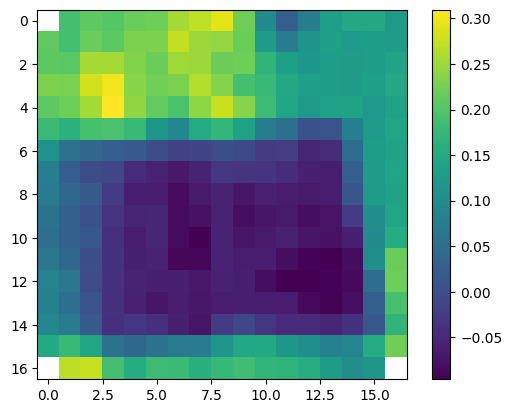

In [134]:
NDVI_arr = single_time_patch.variables['ndvi']

ARR = NDVI_arr.values
print(type(ARR))

import matplotlib.pyplot as plt
plt.imshow(ARR)
plt.colorbar()

In [116]:
print(masked_patch.di)

AttributeError: 'Dataset' object has no attribute 'di'

In [50]:
print(masked_patch['time'][0].coords)

Coordinates:
    epsg     int64 8B ...
    time     datetime64[ns] 8B 2021-01-05T03:34:59.828000


In [33]:
!pip install xarray zarr

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)